# 식물 질병 분류
- multiclass classifcation

In [1]:
import pandas as pd
import numpy as np
import random
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image

import torch
import torchvision.transforms as T

import timm
from sklearn.metrics import accuracy_score

/opt/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <2BD1B165-EC09-3F68-BCE4-8FE4E70CA7E2> /opt/anaconda3/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <9C467D80-5BAC-3156-B480-F0FF7E45DEF2> /opt/anaconda3/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

device = 'mps'

# CustomDataset

In [3]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_path, classes, transforms):
        super().__init__()
        self.data = []
        self.transforms = transforms

        for i, cls in enumerate(classes):
            cls_path = os.path.join(root_path, cls)
            img_list = os.listdir(cls_path)
            for img in img_list:
                if img != '.DS_Store' and img != '.ipynb_checkpoints':
                    img_path = os.path.join(cls_path, img)
                    self.data.append((img_path, i))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = Image.open(self.data[idx][0]).convert('RGB')
        img = self.transforms(img)
        label = self.data[idx][1]

        return img, label

In [4]:
classes = ['cbb', 'cbsd', 'cgm', 'cmd', 'healthy']
transforms = T.Compose([
    T.Resize((64, 64)),
    T.ToTensor()
])

total_dataset = CustomDataset('/Users/kimhongseok/cv_79_projects/part2/14/data/train', classes, transforms)
print(len(total_dataset))

4792


In [5]:
total_num = len(total_dataset)
train_num, valid_num, test_num = int(total_num*0.8), int(total_num*0.1), int(total_num*0.1)

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(total_dataset, [train_num+1, valid_num, test_num])

In [6]:
print(len(train_dataset), len(valid_dataset), len(test_dataset))

3834 479 479


In [7]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# train, eval

In [8]:
def training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs):
    model.train()
    train_loss = 0.0
    train_accuracy = 0

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        max_prob, preds = torch.max(probs, 1)
        train_accuracy += (preds==labels).sum().item()

        tbar.set_description(f'Epoch/Epochs [{epoch}/{num_epochs}] Train Loss: {loss.item():.4f}')

    train_loss /= len(train_dataloader)
    train_accuracy /= len(train_dataset)

    return model, train_loss, train_accuracy

def evaluation(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs):
    model.eval()
    valid_loss = 0.0
    valid_accuracy = 0

    with torch.no_grad():
        tbar = tqdm(valid_dataloader)
        for images, labels in tbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            max_prob, preds = torch.max(probs, 1)
            valid_accuracy += (preds==labels).sum().item()

            tbar.set_description(f'Epoch/Epochs [{epoch}/{num_epochs}] Valid Loss: {loss.item():.4f}')

    valid_loss /= len(valid_dataloader)
    valid_accuracy /= len(valid_dataset)

    return model, valid_loss, valid_accuracy

def training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, num_epochs):
    model.to(device)
    for epoch in range(num_epochs):
        model, train_loss, train_accuracy = training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs)
        model, valid_loss, valid_accuracy = evaluation(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs)

        print(f'Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Valid Loss: {valid_loss}, Valid Accuracy: {valid_accuracy}')

    return model

# model

In [9]:
model = timm.create_model(
    'resnet18',
    pretrained=True,
    num_classes=len(classes)
)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [11]:
for params in model.parameters():
    params.require_grads = False

for params in model.fc.parameters():
    params.require_grads = True

In [12]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model = training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, 10)

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 1.1570293471217155, Train Accuracy: 0.5584246218049035, Valid Loss: 1.0789947112401326, Valid Accuracy: 0.5657620041753654


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.8604940856496494, Train Accuracy: 0.6731872717788211, Valid Loss: 1.042801566918691, Valid Accuracy: 0.5908141962421712


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.6078950996200244, Train Accuracy: 0.7743870631194575, Valid Loss: 1.158011217912038, Valid Accuracy: 0.5949895615866388


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.39632327208916346, Train Accuracy: 0.8510693792383933, Valid Loss: 1.9114543279012044, Valid Accuracy: 0.4091858037578288


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.31675761795292295, Train Accuracy: 0.8862806468440271, Valid Loss: 1.3845357656478883, Valid Accuracy: 0.6075156576200418


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.2285899485150973, Train Accuracy: 0.9196661450182577, Valid Loss: 1.4438095211982727, Valid Accuracy: 0.6179540709812108


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.14855625346923867, Train Accuracy: 0.949660928534168, Valid Loss: 1.6659801165262857, Valid Accuracy: 0.6179540709812108


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.16067411354742944, Train Accuracy: 0.9478351591027647, Valid Loss: 1.7524011691411336, Valid Accuracy: 0.6137787056367432


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.13433238433984418, Train Accuracy: 0.9543557642149192, Valid Loss: 1.5620922088623046, Valid Accuracy: 0.5970772442588727


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.10891904648160562, Train Accuracy: 0.9629629629629629, Valid Loss: 1.7848608334859213, Valid Accuracy: 0.6033402922755741


# test

In [13]:
model.eval()
total_labels = []
total_preds = []

with torch.no_grad():
    tbar = tqdm(test_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        
        max_prob, preds = torch.max(probs, 1)

        total_labels.extend(labels.cpu().numpy())
        total_preds.extend(preds.cpu().numpy())

  0%|          | 0/15 [00:00<?, ?it/s]

In [14]:
accuracy_score(total_labels, total_preds)

0.6304801670146137

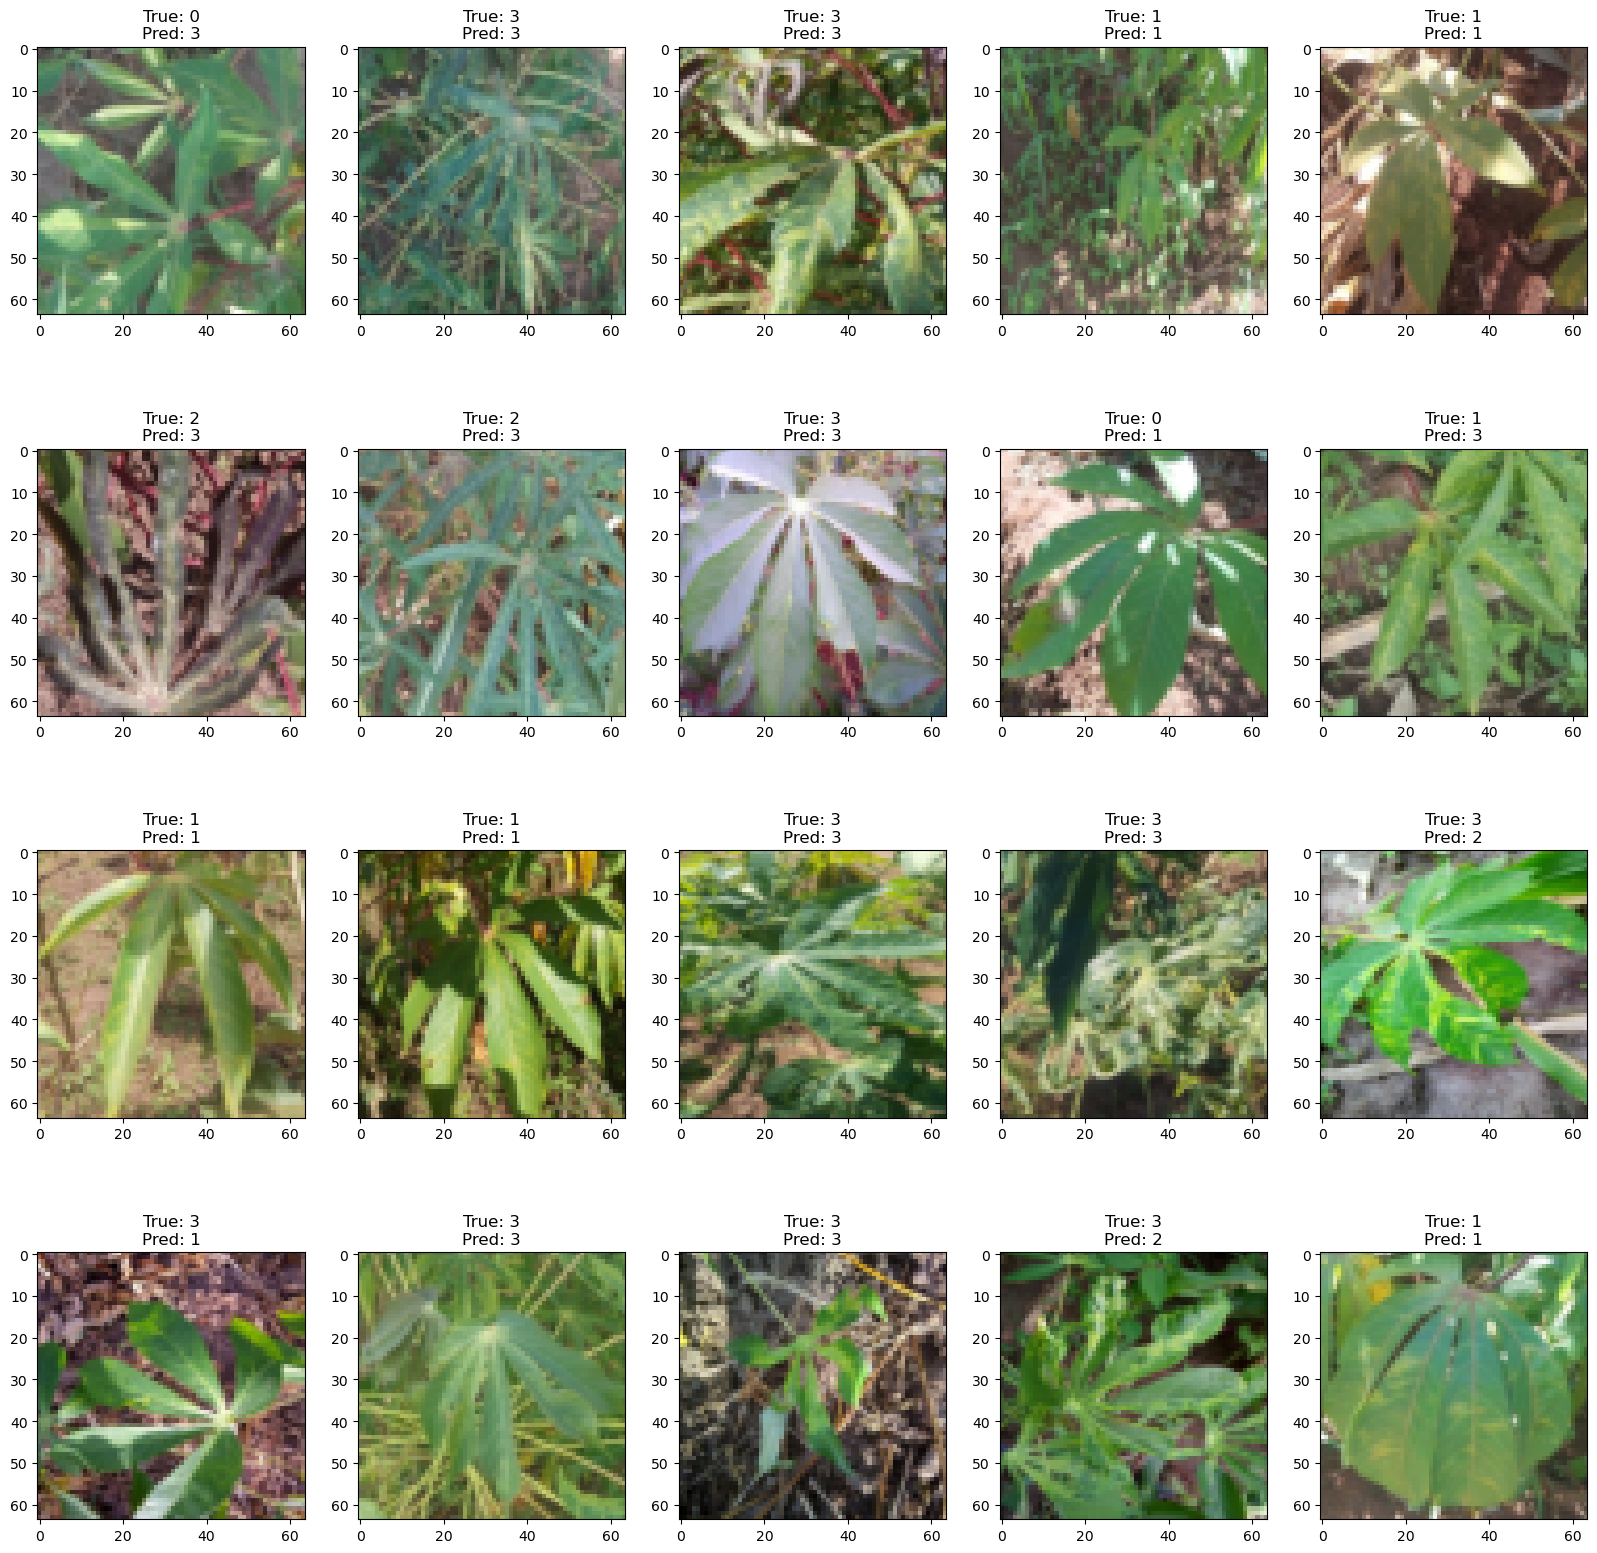

In [15]:
plt.figure(figsize=(20, 20))

for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(test_dataset[i][0].permute(1, 2, 0))
    plt.title(f'True: {total_labels[i]}\nPred: {total_preds[i]}')